# Classification with QKS and projected-QKS algorithms

## Global imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Qiskit
from qiskit.circuit import QuantumCircuit, ParameterVector

# Scikit
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, GridSearchCV 
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

from qks.QuantumKitchenSinks import QuantumKitchenSinks
from qks.ProjectedQuantumKitchenSinks import ProjectedQuantumKitchenSinks

seed = 12345
np.random.seed(seed)

## Moons dataset

In [2]:
from sklearn.datasets import make_moons
from sklearn.preprocessing import MinMaxScaler
from qks.visualization_tools import plot_dataset, plot_predictions, plot_decisions

n_samples = 100
X, y = make_moons(n_samples=n_samples, noise=0.2, random_state=22)
y = 2*y-1

# Data rescaling
xmin = -1; xmax = 1
X = MinMaxScaler(feature_range=(xmin, xmax), copy=False).fit_transform(X)

train_size = 15
test_size = 15
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, 
    test_size=test_size,
    stratify=y,
    random_state=seed
)

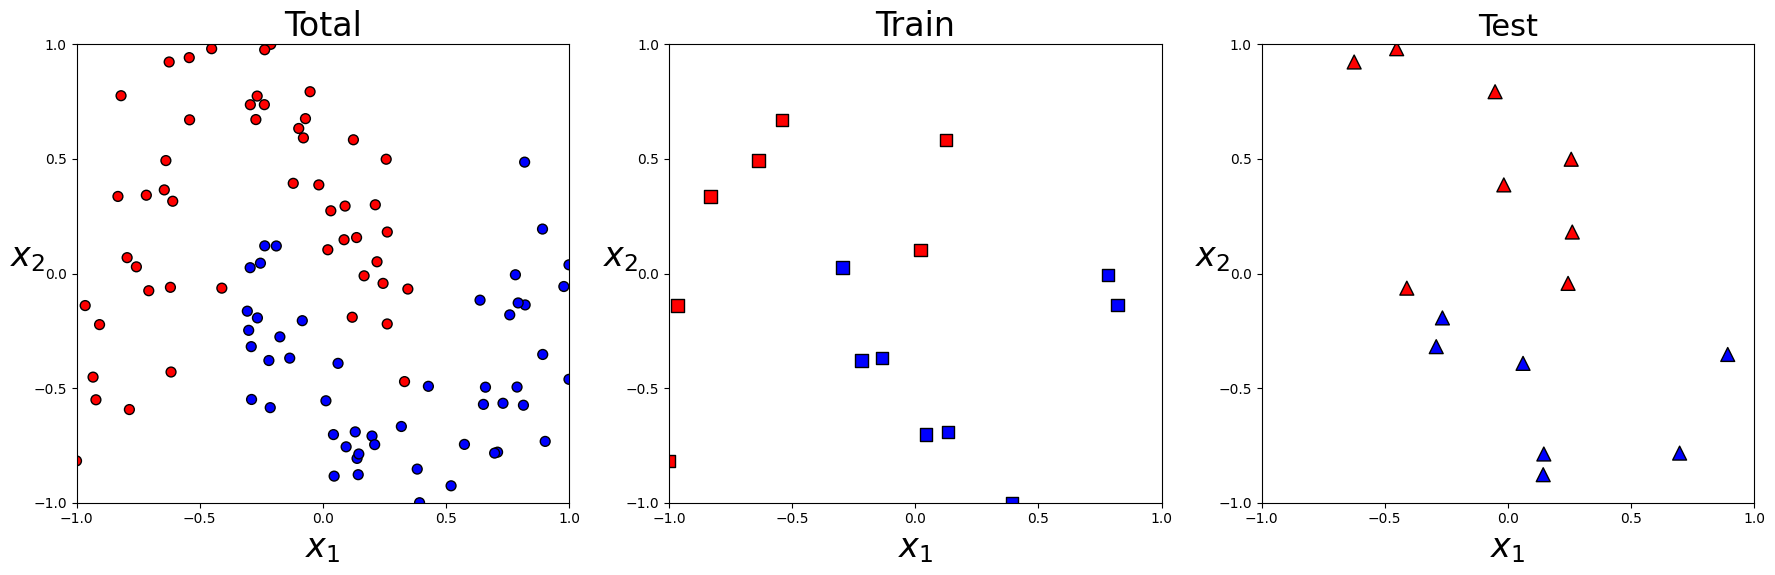

In [3]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=24)
plot_dataset(X, y, ax1, axes)

ax2.set_title("Train", fontsize=24)
plot_dataset(X_train, y_train, ax2, axes, marker='s', size=80)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='^', size=100)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Classical kernel RBF-SVC

In [4]:
from sklearn.svm import SVC

param_grid = {
    "gamma": [0.001, 0.005, 0.01, 0.1, 0.5, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 5.0, 10.0],
    "C": [1, 2, 4, 6, 8, 10, 100, 1000],
}

gs = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=seed),
)
gs.fit(X_train, y_train)

print('Best grid search parameters:', gs.best_params_)
print('Best training score:', gs.best_score_)
clf = gs.best_estimator_

y_pred = clf.predict(X_train)
acc_tr = metrics.balanced_accuracy_score(y_true=y_train, y_pred=y_pred)
mcc_tr = metrics.matthews_corrcoef(y_true=y_train, y_pred=y_pred)

y_pred = clf.predict(X_test)
acc_te = metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
mcc_te = metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred)

print()
print(f"Scores ACC-MCC (train - test):  {acc_tr:.2f} {mcc_tr:.2f}    {acc_te:.2f} {mcc_te:.2f}")
print()

Best grid search parameters: {'C': 2, 'gamma': 5.0}
Best training score: 1.0

Scores ACC-MCC (train - test):  1.00 1.00    0.94 0.88



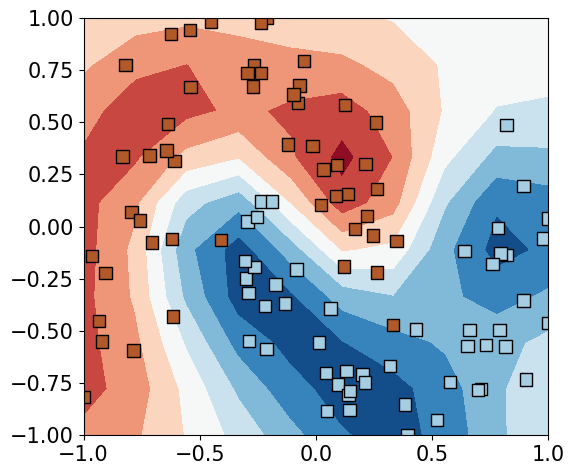

Timing info: 00h00m00s


In [5]:
t0 = time.perf_counter()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

N = 10
x0s = np.linspace(xmin, xmax, N)
x1s = np.linspace(xmin, xmax, N)
x0, x1 = np.meshgrid(x0s, x1s)
XX = np.c_[x0.ravel(), x1.ravel()]
y_pred = clf.decision_function(XX).reshape(x0.shape)
ax.contourf(x0, x1, y_pred, cmap=plt.cm.RdBu, alpha=1.0)

ax.scatter(X[:, 0], X[:, 1], s=80, c=y, 
           marker='s', cmap=plt.cm.Paired_r, edgecolors="k")
plt.tight_layout()
plt.show()
t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

## Quantum Kitchen Sinks

In [6]:
#####################################################
# Wrapper for the quantum kitchen sinks classifier
#####################################################

def clf_QKS(fm, X_train, y_train, X_test, y_test, n_episodes, stddev):
    """ """
    n_features = len(X_train[0])
    qks = QuantumKitchenSinks(
        n_features, fm,
        n_episodes=n_episodes, stddev=stddev, sampling='normal',
        seed=seed
    )
    emb_tr = qks.embedding(X_train)
    clf = LogisticRegression(random_state=seed, max_iter=1000).fit(emb_tr, y_train)
    
    y_pred = clf.predict(emb_tr)
    acc_tr = metrics.balanced_accuracy_score(y_true=y_train, y_pred=y_pred)
    mcc_tr = metrics.matthews_corrcoef(y_true=y_train, y_pred=y_pred)
    
    emb_te = qks.embedding(X_test)
    y_pred = clf.predict(emb_te)
    acc_te = metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    mcc_te = metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    
    return clf, qks, [acc_tr, mcc_tr, acc_te, mcc_te]

In [12]:
#############################################################
# Feature Map
#############################################################
n_features = len(X[0])
n_qubits = 2
n_layers = 1
n_params = 2

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_params], i); j += 1
    for i in range(n_qubits-1):
        fm.cx(i, i+1)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# QKS
#############################################################
t0 = time.perf_counter()

clf, qks, scores = clf_QKS(fm, X_train, y_train, X_test, y_test, n_episodes=20, stddev=3.0)

print()
print(f"Scores ACC-MCC (train - test):  {scores[0]:.2f} {scores[1]:.2f}    {scores[2]:.2f} {scores[3]:.2f}")
print()

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

     ┌──────────┐     
q_0: ┤ Ry(θ[0]) ├──■──
     ├──────────┤┌─┴─┐
q_1: ┤ Ry(θ[1]) ├┤ X ├
     └──────────┘└───┘

Scores ACC-MCC (train - test):  1.00 1.00    0.94 0.88

Timing info: 00h00m08s


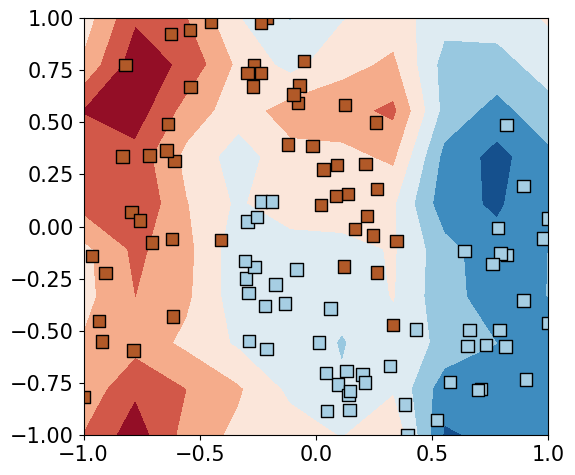

Timing info: 00h00m29s


In [13]:
t0 = time.perf_counter()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

N = 10
x0s = np.linspace(xmin, xmax, N)
x1s = np.linspace(xmin, xmax, N)
x0, x1 = np.meshgrid(x0s, x1s)
XX = np.c_[x0.ravel(), x1.ravel()]
emb_X = qks.embedding(XX)
y_pred = clf.decision_function(emb_X).reshape(x0.shape)
ax.contourf(x0, x1, y_pred, cmap=plt.cm.RdBu, alpha=1.0)

ax.scatter(X[:, 0], X[:, 1], s=80, c=y, 
           marker='s', cmap=plt.cm.Paired_r, edgecolors="k")
plt.tight_layout()
plt.show()
t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

## Projected Quantum Kitchen Sinks

In [9]:
##############################################################
# Wrapper for the projected quantum kitchen sinks classifier
##############################################################

def clf_pQKS(fm, X_train, y_train, X_test, y_test, n_episodes, stddev, proj='z'):
    """ """
    n_features = len(X_train[0])
    qks = ProjectedQuantumKitchenSinks(
        n_features, fm, projection=proj,
        n_episodes=n_episodes, stddev=stddev, sampling='normal',
        seed=seed, method='statevector'
    )
    emb_tr = qks.embedding(X_train)
    clf = LogisticRegression(random_state=seed, max_iter=1000).fit(emb_tr, y_train)
    
    y_pred = clf.predict(emb_tr)
    acc_tr = metrics.balanced_accuracy_score(y_true=y_train, y_pred=y_pred)
    mcc_tr = metrics.matthews_corrcoef(y_true=y_train, y_pred=y_pred)
    
    emb_te = qks.embedding(X_test)
    y_pred = clf.predict(emb_te)
    acc_te = metrics.balanced_accuracy_score(y_true=y_test, y_pred=y_pred)
    mcc_te = metrics.matthews_corrcoef(y_true=y_test, y_pred=y_pred)
    
    return clf, qks, [acc_tr, mcc_tr, acc_te, mcc_te]

In [14]:
#############################################################
# Feature Map
#############################################################
n_features = len(X[0])
n_qubits = 2
n_layers = 1
n_params = 2

theta = ParameterVector('θ', length=n_params)
fm = QuantumCircuit(n_qubits)

j = 0
for r in range(n_layers):
    for i in range(n_qubits):
        fm.ry(theta[j%n_params], i); j += 1
    for i in range(n_qubits-1):
        fm.cx(i, i+1)
print(fm.draw(fold=120, plot_barriers=False))

#############################################################
# Projected QKS
#############################################################
t0 = time.perf_counter()

clf, qks, scores = clf_pQKS(fm, X_train, y_train, X_test, y_test, n_episodes=20, stddev=3.0, proj='xyz')

print()
print(f"Scores ACC-MCC (train - test):  {scores[0]:.2f} {scores[1]:.2f}    {scores[2]:.2f} {scores[3]:.2f}")
print()

t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )

     ┌──────────┐     
q_0: ┤ Ry(θ[0]) ├──■──
     ├──────────┤┌─┴─┐
q_1: ┤ Ry(θ[1]) ├┤ X ├
     └──────────┘└───┘

Scores ACC-MCC (train - test):  1.00 1.00    0.94 0.88

Timing info: 00h00m02s


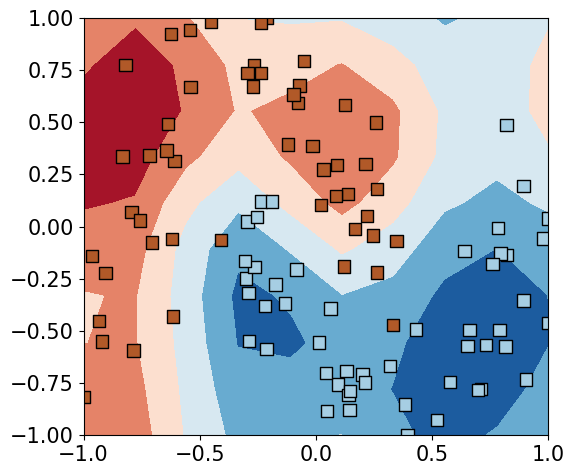

Timing info: 00h00m09s


In [15]:
t0 = time.perf_counter()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

N = 10
x0s = np.linspace(xmin, xmax, N)
x1s = np.linspace(xmin, xmax, N)
x0, x1 = np.meshgrid(x0s, x1s)
XX = np.c_[x0.ravel(), x1.ravel()]
emb_X = qks.embedding(XX)
y_pred = clf.decision_function(emb_X).reshape(x0.shape)
ax.contourf(x0, x1, y_pred, cmap=plt.cm.RdBu, alpha=1.0)

ax.scatter(X[:, 0], X[:, 1], s=80, c=y, 
           marker='s', cmap=plt.cm.Paired_r, edgecolors="k")
plt.tight_layout()
plt.show()
t1 = time.perf_counter()
print( 'Timing info:', time.strftime("%Hh%Mm%Ss", time.gmtime(t1-t0)) )